Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}
Average Training Metrics:
RMSE: 238.38164642977145
MAE: 158.0671010418902
R-squared: 0.9854389623172344
MAPE: 11.402003561767646

Average Validation Metrics:
RMSE: 412.85431883341846
MAE: 244.84132354649506
R-squared: 0.955702443101236
MAPE: 102.71525871326803

Test Metrics:
RMSE: 294.9033533451483
MAE: 196.38125218822339
R-squared: 0.9787895163324744
MAPE: 9.271156383833326


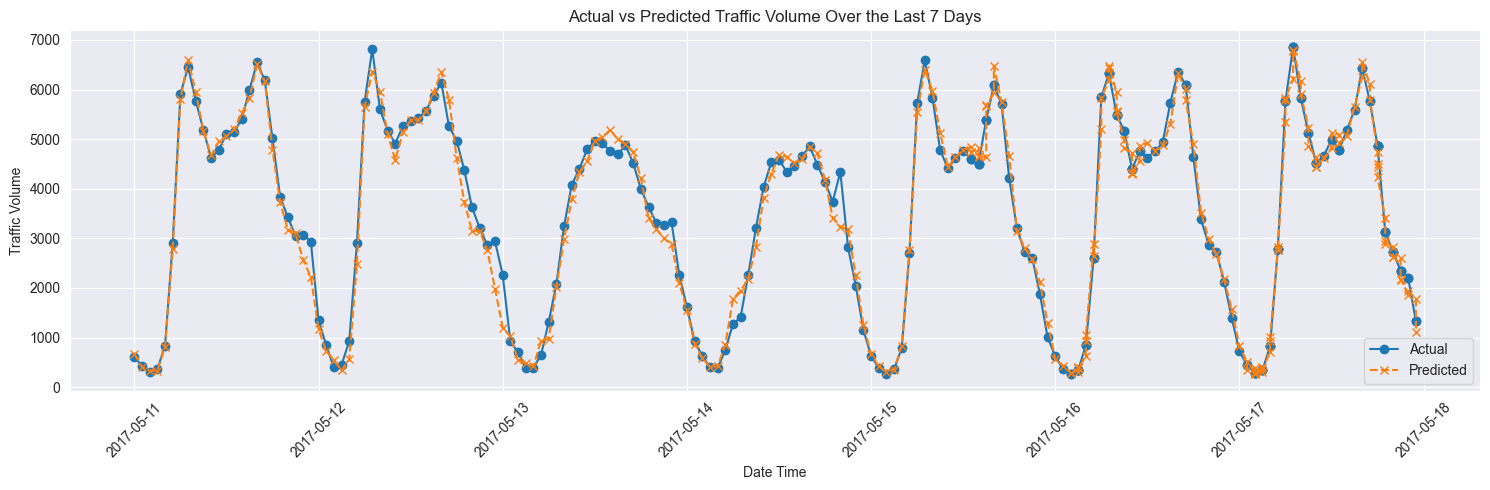

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorer from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Convert 'is_holiday' from categorical to binary (1 for any holiday, 0 for non-holiday)
df_raw['is_holiday'] = df_raw['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Split the dataset into numerical and categorical features for scaling
X_numerical = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(exclude=[np.number])

# Scale the numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Combine scaled numerical and categorical features
X_scaled = np.concatenate((X_numerical_scaled, X_categorical), axis=1)

# Perform the train-test split for the last part of the analysis
total_samples = X_scaled.shape[0]
split_index = int(total_samples * 0.9)
X_train_scaled_test = X_scaled[:split_index]
y_train_test = y[:split_index]
X_test_scaled = X_scaled[split_index:]
y_test = y[split_index:]

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost regressor with default parameters
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Initialize the RandomizedSearchCV object with the time series cross-validator
random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit the random search to the scaled data
random_search.fit(X_scaled, y)

# Get the best parameters
best_parameters = random_search.best_params_
print(f"Best parameters found: {best_parameters}")

# Train the best model on the scaled data
best_model = random_search.best_estimator_

# Initialize lists to store metrics for each fold
train_rmse_list, train_mae_list, train_mape_list, train_r2_list = [], [], [], []
val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], []

# Perform TimeSeriesSplit and evaluate the model for each fold
for train_index, val_index in tscv.split(X_scaled):
    X_train_scaled, X_val_scaled = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the model on the training data
    best_model.fit(X_train_scaled, y_train)

    # Predict on the training set
    y_train_pred = best_model.predict(X_train_scaled)

    # Calculate and store metrics for the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape_score = mape_scorer(y_train, y_train_pred)

    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
    train_r2_list.append(train_r2)
    train_mape_list.append(train_mape_score)

    # Predict on the validation set
    y_val_pred = best_model.predict(X_val_scaled)

    # Calculate and store metrics for the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_mape_score = mape_scorer(y_val, y_val_pred)

    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)
    val_r2_list.append(val_r2)
    val_mape_list.append(val_mape_score)

# Print the average metrics over all folds
print("Average Training Metrics:")
print(f"RMSE: {np.mean(train_rmse_list)}")
print(f"MAE: {np.mean(train_mae_list)}")
print(f"R-squared: {np.mean(train_r2_list)}")
print(f"MAPE: {np.mean(train_mape_list)}")

print("\nAverage Validation Metrics:")
print(f"RMSE: {np.mean(val_rmse_list)}")
print(f"MAE: {np.mean(val_mae_list)}")
print(f"R-squared: {np.mean(val_r2_list)}")
print(f"MAPE: {np.mean(val_mape_list)}")

# Now, use the last train-test split for the final evaluation on unseen data
# Fit the model on the training data
best_model.fit(X_train_scaled_test, y_train_test)

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate the metrics for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape_score = mape_scorer(y_test, y_test_pred)

# Print the test metrics
print("\nTest Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R-squared: {test_r2}")
print(f"MAPE: {test_mape_score}")

# Plot the results for the last 7 days of the test set
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred}, index=y_test.index)
last_7_days = comparison_df.last('7D')  # '7D' for 7 days

plt.figure(figsize=(15, 5))
plt.plot(last_7_days['Actual'], label='Actual', marker='o')
plt.plot(last_7_days['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
